In [1]:
# Install necessary libraries
!pip install librosa pandas scikit-learn seaborn matplotlib tqdm datasets

# Create a directory for the dataset
!mkdir -p /content/SpeechCommands

# Navigate to the dataset directory
%cd /content/SpeechCommands

# Download the dataset
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

# Extract the dataset
!tar -xvzf speech_commands_v0.02.tar.gz

# Remove the tar.gz file to save space
!rm speech_commands_v0.02.tar.gz


Streaming output truncated to the last 5000 lines.
./on/fc3ba625_nohash_0.wav
./on/db9d52d2_nohash_0.wav
./on/72242187_nohash_4.wav
./on/b0f5b16d_nohash_0.wav
./on/d9aa8c90_nohash_1.wav
./on/525eaa62_nohash_0.wav
./on/42e3f068_nohash_0.wav
./on/94d370bf_nohash_4.wav
./on/bf8d5617_nohash_0.wav
./on/e2b7d6d6_nohash_2.wav
./on/89ed36ab_nohash_0.wav
./on/30276d03_nohash_1.wav
./on/364c0853_nohash_0.wav
./on/7cbf645a_nohash_0.wav
./on/c98bbbd3_nohash_2.wav
./on/9a7c1f83_nohash_5.wav
./on/3589bc72_nohash_0.wav
./on/3ae5c04f_nohash_0.wav
./on/adc216c5_nohash_2.wav
./on/c50f55b8_nohash_15.wav
./on/324210dd_nohash_2.wav
./on/c120e80e_nohash_2.wav
./on/69086eb0_nohash_0.wav
./on/dce05676_nohash_1.wav
./on/435695e3_nohash_1.wav
./on/179a61b7_nohash_1.wav
./on/f5341341_nohash_0.wav
./on/91b03183_nohash_0.wav
./on/96d8bb6f_nohash_2.wav
./on/6a1908f8_nohash_0.wav
./on/6ace4fe1_nohash_1.wav
./on/84d1e469_nohash_1.wav
./on/ba676390_nohash_0.wav
./on/1dc86f91_nohash_4.wav
./on/3a929277_nohash_2.wav
./o

In [2]:
import os
import glob
import pandas as pd
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [3]:
# List of target words to recognize
target_words = [
    "yes",
    "no",
    "up",
    "down",
    "left",
    "right",
    "on",
    "off",
    "stop",
    "go"
]

# Path to the dataset directory
DATASET_PATH = '/content/SpeechCommands'

# Initialize lists to hold file paths and labels
audio_paths = []
labels = []

# Iterate through each target word directory and collect file paths
for label in target_words:
    # Path to the current word's audio files
    word_dir = os.path.join(DATASET_PATH, label)

    # Check if the directory exists
    if not os.path.exists(word_dir):
        print(f"Directory for '{label}' not found in the dataset.")
        continue

    # Collect all .wav files in the directory
    files = glob.glob(os.path.join(word_dir, "*.wav"))

    # Append file paths and labels
    audio_paths.extend(files)
    labels.extend([label] * len(files))

# Create a DataFrame
data = pd.DataFrame({'audio_path': audio_paths, 'label': labels})
print(f"Total samples collected: {len(data)}")


Total samples collected: 38546


In [4]:
# Determine the minimum number of samples among all classes
min_samples = data['label'].value_counts().min()
print(f"Minimum samples per class: {min_samples}")

# Downsample each class to the minimum number of samples
from sklearn.utils import resample

balanced_data = data.groupby('label').apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)
print(f"Balanced dataset size: {len(balanced_data)}")

# Verify the distribution
print(balanced_data['label'].value_counts())


Minimum samples per class: 3723
Balanced dataset size: 37230
label
down     3723
go       3723
left     3723
no       3723
off      3723
on       3723
right    3723
stop     3723
up       3723
yes      3723
Name: count, dtype: int64


In [6]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform labels
y = le.fit_transform(balanced_data['label'])

# Display classes
print(f"Classes: {le.classes_}")


Classes: ['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'up' 'yes']


In [7]:
def extract_features(file_path, n_mfcc=13):
    try:
        # Load audio file
        y_audio, sr = librosa.load(file_path, sr=16000)
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=n_mfcc)
        # Compute mean and standard deviation
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        # Compute delta (first derivative) and delta-delta (second derivative)
        delta_mfccs = np.mean(librosa.feature.delta(mfccs), axis=1)
        delta2_mfccs = np.mean(librosa.feature.delta(mfccs, order=2), axis=1)
        # Concatenate all features
        feature_vector = np.concatenate((mfccs_mean, mfccs_std, delta_mfccs, delta2_mfccs))
        return feature_vector
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [8]:
# Initialize lists to hold features and labels
features = []
labels = []

print("Extracting features from audio files...")

for idx, row in tqdm(balanced_data.iterrows(), total=len(balanced_data)):
    mfcc = extract_features(row['audio_path'])
    if mfcc is not None:
        features.append(mfcc)
        labels.append(row['label'])

# Convert to numpy arrays
X = np.array(features)
y = y[:len(X)]  # Adjust labels if any samples were skipped
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Extracting features from audio files...


100%|██████████| 37230/37230 [07:43<00:00, 80.35it/s]

Feature matrix shape: (37230, 52)
Labels shape: (37230,)


In [9]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 29784
Testing set size: 7446


In [10]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)


In [11]:
from sklearn.decomposition import PCA

# Initialize PCA to retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA on training data and transform
X_train_pca = pca.fit_transform(X_train_scaled)
print(f"Reduced training feature matrix shape: {X_train_pca.shape}")

# Transform testing data
X_test_pca = pca.transform(X_test_scaled)
print(f"Reduced testing feature matrix shape: {X_test_pca.shape}")


Reduced training feature matrix shape: (29784, 45)
Reduced testing feature matrix shape: (7446, 45)


In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize Regularized K-Nearest Neighbors
knn_regularized = KNeighborsClassifier(n_neighbors=10)  # Increased from 5 to 10


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Regularized Random Forest
random_forest_reg = RandomForestClassifier(
    n_estimators=100,            # Number of trees
    max_depth=10,                # Limiting tree depth from default (None)
    min_samples_split=5,         # Increasing from default (2)
    min_samples_leaf=2,          # Increasing from default (1)
    max_features='sqrt',         # Reducing the number of features considered for splitting
    bootstrap=True,              # Using bootstrap samples
    random_state=42
)


In [14]:
from sklearn.svm import SVC

# Initialize Regularized SVM with RBF Kernel
svm_reg = SVC(
    kernel='rbf',
    C=0.5,                        # Reduced from default (1.0) to increase regularization
    gamma='scale',                # 'scale' is default; can experiment with other values if needed
    probability=True,
    random_state=42
)


In [15]:
# Function to evaluate and plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name, dataset_type='Test'):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name} Confusion Matrix ({dataset_type} Data)')
    plt.show()

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Predictions on Training Data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Predictions on Testing Data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Print Accuracies
    print(f"{model_name} Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%\n")

    # Classification Report for Test Data
    print(f"{model_name} Classification Report (Test Data):")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Confusion Matrix for Test Data
    cm_test = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm_test, le.classes_, model_name, dataset_type='Test')

    # Confusion Matrix for Training Data
    cm_train = confusion_matrix(y_train, y_train_pred)
    plot_confusion_matrix(cm_train, le.classes_, model_name, dataset_type='Train')

    return train_accuracy, test_accuracy


Training Regularized K-Nearest Neighbors...
Regularized K-Nearest Neighbors training completed.

Regularized K-Nearest Neighbors Train Accuracy: 64.99%
Regularized K-Nearest Neighbors Test Accuracy: 51.02%

Regularized K-Nearest Neighbors Classification Report (Test Data):
              precision    recall  f1-score   support

        down       0.37      0.56      0.45       744
          go       0.39      0.53      0.45       744
        left       0.56      0.43      0.49       745
          no       0.38      0.51      0.43       745
         off       0.56      0.54      0.55       745
          on       0.54      0.38      0.45       744
       right       0.58      0.57      0.57       745
        stop       0.66      0.47      0.55       745
          up       0.50      0.40      0.45       744
         yes       0.83      0.71      0.77       745

    accuracy                           0.51      7446
   macro avg       0.54      0.51      0.51      7446
weighted avg       0.5

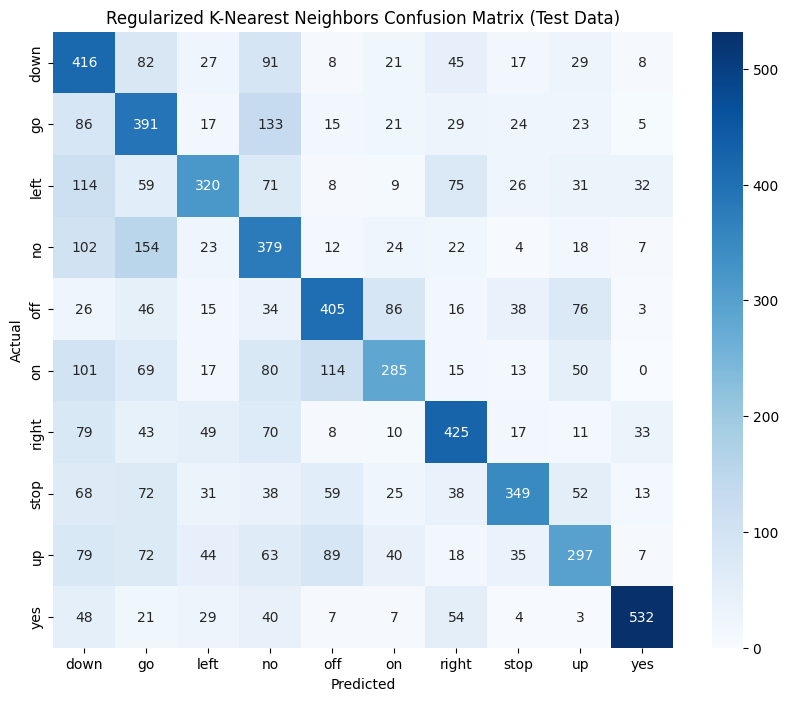

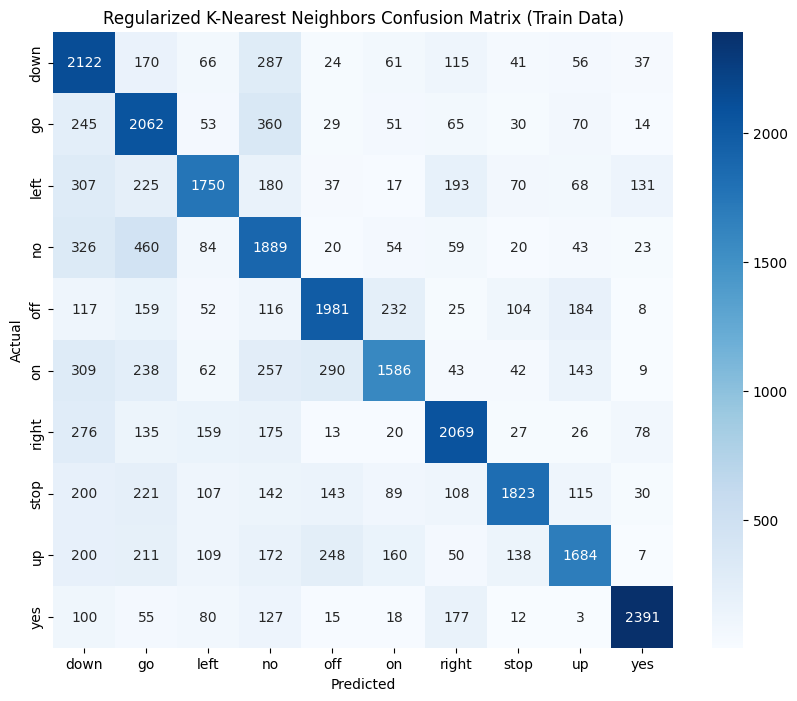

In [16]:
print("Training Regularized K-Nearest Neighbors...")
knn_regularized.fit(X_train_pca, y_train)
print("Regularized K-Nearest Neighbors training completed.\n")

# Evaluate the regularized KNN
train_acc_knn_reg, test_acc_knn_reg = evaluate_model(
    knn_regularized,
    X_train_pca,
    X_test_pca,
    y_train,
    y_test,
    "Regularized K-Nearest Neighbors"
)


Training Regularized Random Forest...
Regularized Random Forest training completed.

Regularized Random Forest Train Accuracy: 78.68%
Regularized Random Forest Test Accuracy: 47.48%

Regularized Random Forest Classification Report (Test Data):
              precision    recall  f1-score   support

        down       0.41      0.34      0.37       744
          go       0.42      0.34      0.38       744
        left       0.45      0.35      0.39       745
          no       0.44      0.40      0.42       745
         off       0.49      0.58      0.53       745
          on       0.43      0.45      0.44       744
       right       0.47      0.55      0.51       745
        stop       0.57      0.53      0.55       745
          up       0.42      0.41      0.42       744
         yes       0.61      0.79      0.69       745

    accuracy                           0.47      7446
   macro avg       0.47      0.47      0.47      7446
weighted avg       0.47      0.47      0.47      744

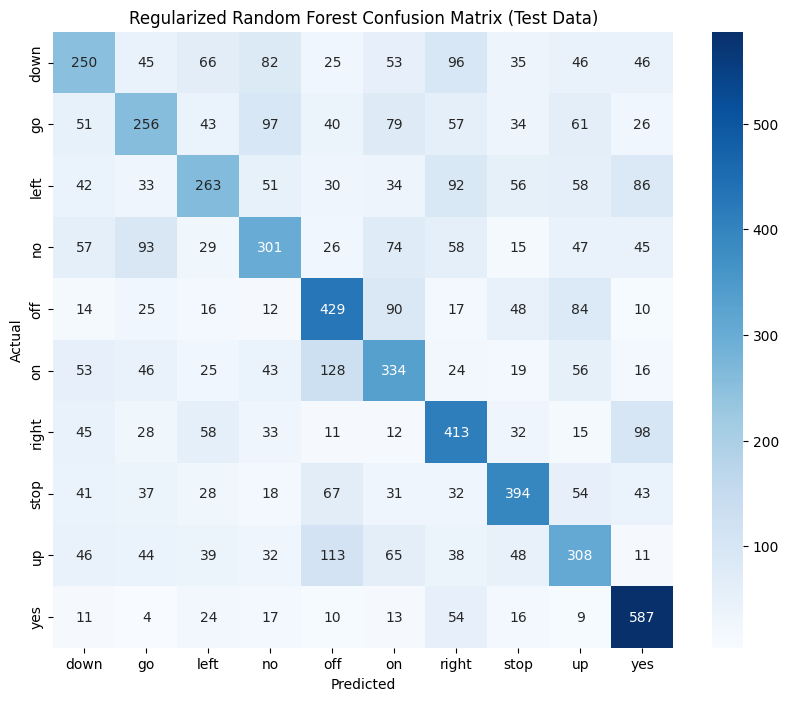

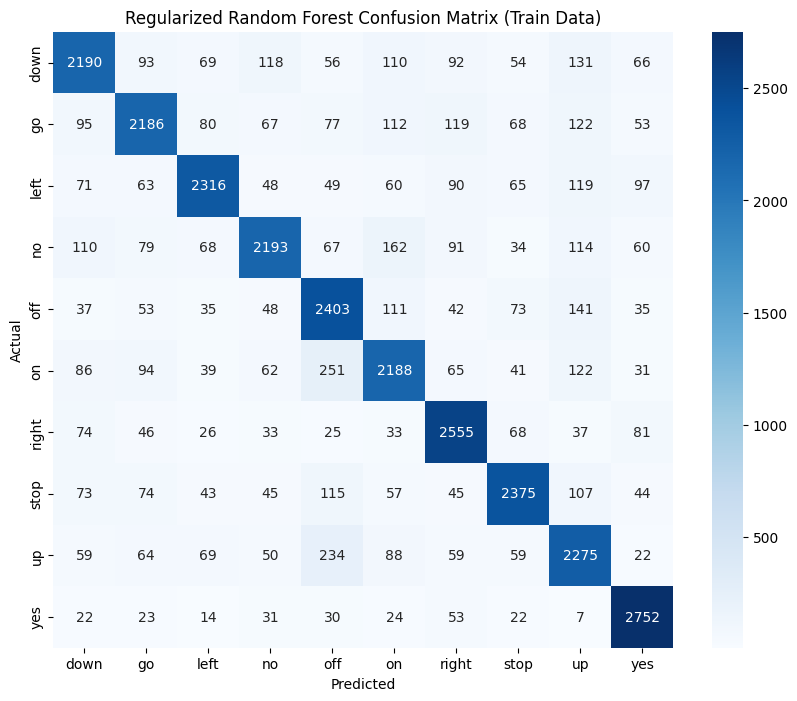

In [17]:
print("Training Regularized Random Forest...")
random_forest_reg.fit(X_train_pca, y_train)
print("Regularized Random Forest training completed.\n")

# Evaluate the regularized Random Forest
train_acc_rf_reg, test_acc_rf_reg = evaluate_model(
    random_forest_reg,
    X_train_pca,
    X_test_pca,
    y_train,
    y_test,
    "Regularized Random Forest"
)


Training Regularized SVM with Gaussian (RBF) Kernel...
Regularized SVM with Gaussian (RBF) Kernel training completed.

Regularized SVM with Gaussian (RBF) Kernel Train Accuracy: 72.11%
Regularized SVM with Gaussian (RBF) Kernel Test Accuracy: 62.13%

Regularized SVM with Gaussian (RBF) Kernel Classification Report (Test Data):
              precision    recall  f1-score   support

        down       0.53      0.57      0.55       744
          go       0.53      0.54      0.54       744
        left       0.62      0.65      0.63       745
          no       0.56      0.54      0.55       745
         off       0.63      0.65      0.64       745
          on       0.60      0.55      0.57       744
       right       0.69      0.68      0.69       745
        stop       0.73      0.65      0.69       745
          up       0.53      0.59      0.56       744
         yes       0.82      0.79      0.81       745

    accuracy                           0.62      7446
   macro avg       0.

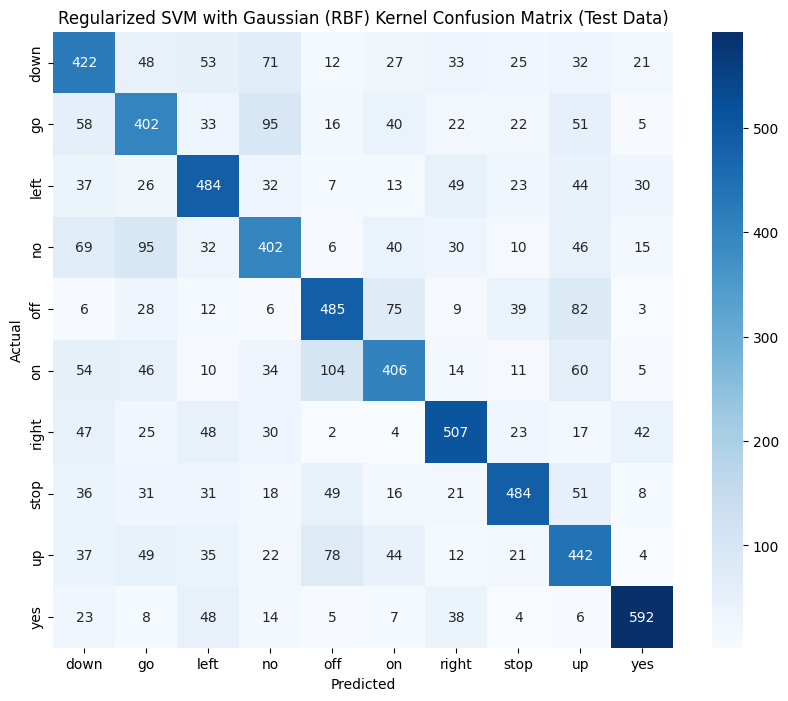

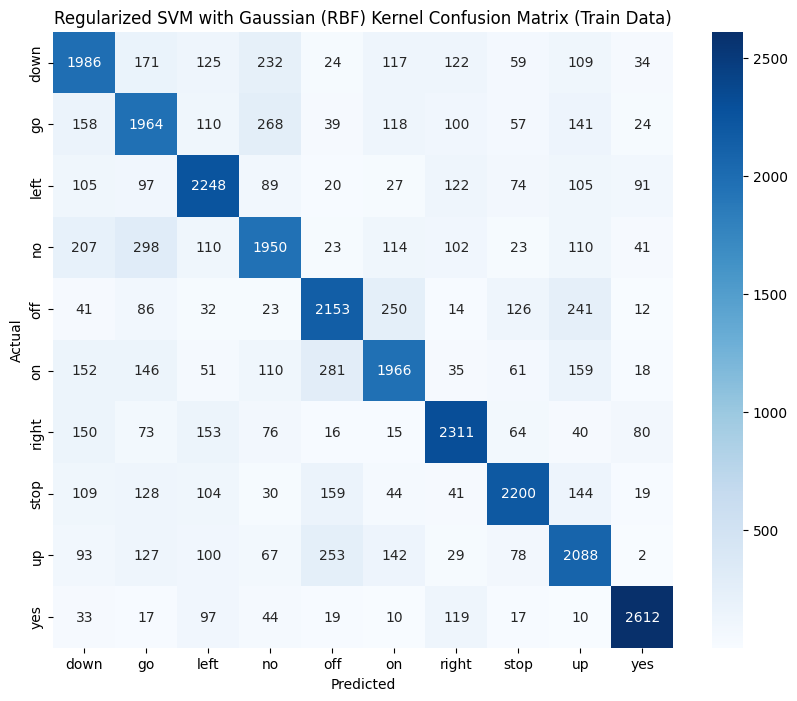

In [18]:
print("Training Regularized SVM with Gaussian (RBF) Kernel...")
svm_reg.fit(X_train_pca, y_train)
print("Regularized SVM with Gaussian (RBF) Kernel training completed.\n")

# Evaluate the regularized SVM
train_acc_svm_reg, test_acc_svm_reg = evaluate_model(
    svm_reg,
    X_train_pca,
    X_test_pca,
    y_train,
    y_test,
    "Regularized SVM with Gaussian (RBF) Kernel"
)


In [19]:
# Create a DataFrame with Regularized Accuracies
results_reg = {
    'Model': [
        'Regularized K-Nearest Neighbors',
        'Regularized Random Forest',
        'Regularized SVM with Gaussian (RBF) Kernel'
    ],
    'Train Accuracy (%)': [
        train_acc_knn_reg * 100,
        train_acc_rf_reg * 100,
        train_acc_svm_reg * 100
    ],
    'Test Accuracy (%)': [
        test_acc_knn_reg * 100,
        test_acc_rf_reg * 100,
        test_acc_svm_reg * 100
    ]
}

df_results_reg = pd.DataFrame(results_reg)
print(df_results_reg)


                                        Model  Train Accuracy (%)  \
0             Regularized K-Nearest Neighbors           64.991270   
1                   Regularized Random Forest           78.676471   
2  Regularized SVM with Gaussian (RBF) Kernel           72.112544   

   Test Accuracy (%)  
0          51.020682  
1          47.475154  
2          62.127317  


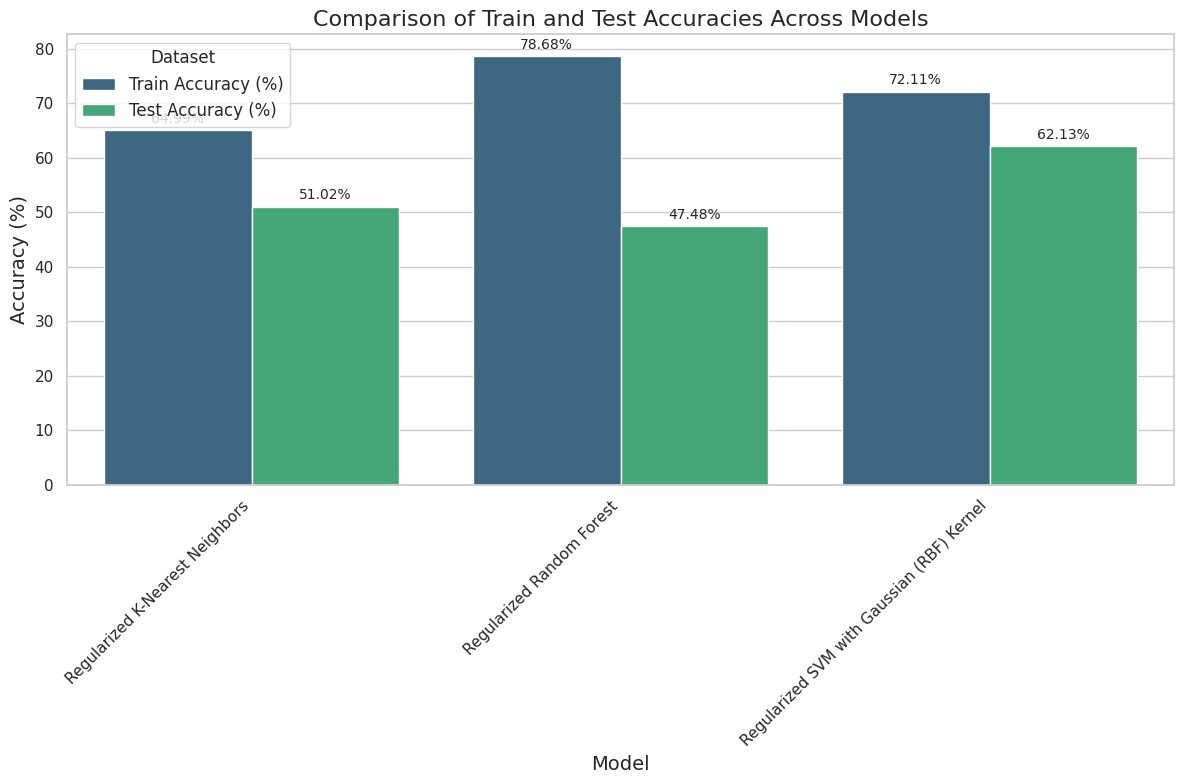

In [20]:
# Generate a bar chart comparing Train and Test Accuracies of the models

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Melt the DataFrame to long-form for easier plotting with seaborn
df_melted = df_results_reg.melt(id_vars='Model',
                                value_vars=['Train Accuracy (%)', 'Test Accuracy (%)'],
                                var_name='Dataset',
                                value_name='Accuracy')

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a barplot
sns.barplot(
    x='Model',
    y='Accuracy',
    hue='Dataset',
    data=df_melted,
    palette='viridis'
)

# Add titles and labels
plt.title('Comparison of Train and Test Accuracies Across Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust legend title
plt.legend(title='Dataset', fontsize=12, title_fontsize=12)

# Annotate bars with accuracy values
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f%%', fontsize=10, padding=3)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()
